First, we load the data:

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

pd.options.display.max_rows = 3

metadata_df = pd.read_csv('src/data/metadata.csv')
word_hist_union_raw_df = pd.read_csv('src/data/features/word_histogram_union_raw.csv')
word_hist_union_pruned_df = pd.read_csv('src/data/features/word_histogram_union_pruned.csv')
word_hist_inter_raw_df = pd.read_csv('src/data/features/word_histogram_inter_raw.csv')
word_hist_inter_pruned_df = pd.read_csv('src/data/features/word_histogram_inter_pruned.csv')

# Find all authors
#list_of_authors = list(set(metadata_df['first_author']))
#print(list_of_authors)

Cleaning the data by merging data of aliases of one author:

In [57]:

def merge_authors(author_name, alias):
    """
    In case one author has multiple aliases, merge the data for this author, so all papers are under the name given by author_name
    Example: 'Florentin Millour' and 'F. Millour' are falsely listed as one author
    Also works with two lists of same length, e.g.
    merge_authors(['Florentin Millour', 'James Leftley'], ['F. Millour', 'J. Leftley'])
    """
    new_metadata_df = metadata_df.replace(alias, author_name)
    return new_metadata_df

metadata_df = merge_authors('Florentin Millour', 'F. Millour')

list_of_authors = list(set(metadata_df['first_author']))

We should also check the total word count of each author and remove authors with no data:

In [59]:
def get_paper_ids_for_author(author):
    paper_ids = list(metadata_df.query(f"first_author=='{author}'")["arxiv_id"])
    return paper_ids

def get_word_count_for_paper(paper_id, words='all'):
    """
        Gets the total word count for a list of words, if 'all' it will get the total word count of this paper
    """
    word_count = 0
    if words== 'all':
        word_row = word_hist_union_raw_df[word_hist_union_raw_df['Data Name'] == float(paper_id)].values.flatten()
        word_count += int(np.sum(word_row[1:]))
    else:
        for word in words:
            word_count += int(word_hist_union_raw_df[word_hist_union_raw_df['Data Name'] == float(paper_id)][word].values[0])
    return word_count

def get_word_count_for_author(author, words='all'):
    """
        Gets the total word count for a list of words, if 'all' it will get the total word count of this author
    """
    word_count = 0
    paper_ids = get_paper_ids_for_author(author)
    if len(paper_ids) == 0:
        print(f'Error: could not find papers for {author}')
    else:
        for paper in paper_ids:
            word_count += get_word_count_for_paper(paper, words=words)
    return int(word_count)

def total_words_by_author():
    author_total_words_dict = {}
    for author in list_of_authors:
        author_total_words_dict[author] = get_word_count_for_author(author)
    return author_total_words_dict
    
# We should remove the authors with a total word count of zero:

def remove_authors(author_list):
    new_metadata_df = metadata_df
    for author in author_list:
        i = new_metadata_df[new_metadata_df.first_author==author].index
        new_metadata_df = new_metadata_df.drop(i, axis=0)
    return new_metadata_df

metadata_df = remove_authors(['Violeta Gamez Rosas', 'Emma P. Lieb'])
list_of_authors = list(set(metadata_df['first_author']))
#print(list_of_authors)

word_totals = total_words_by_author()
##print(word_totals)

Error: could not find papers for nan


Now we look at the relative word frequencies of each author for all words which occur in every paper (word_hist_inter_raw_df)

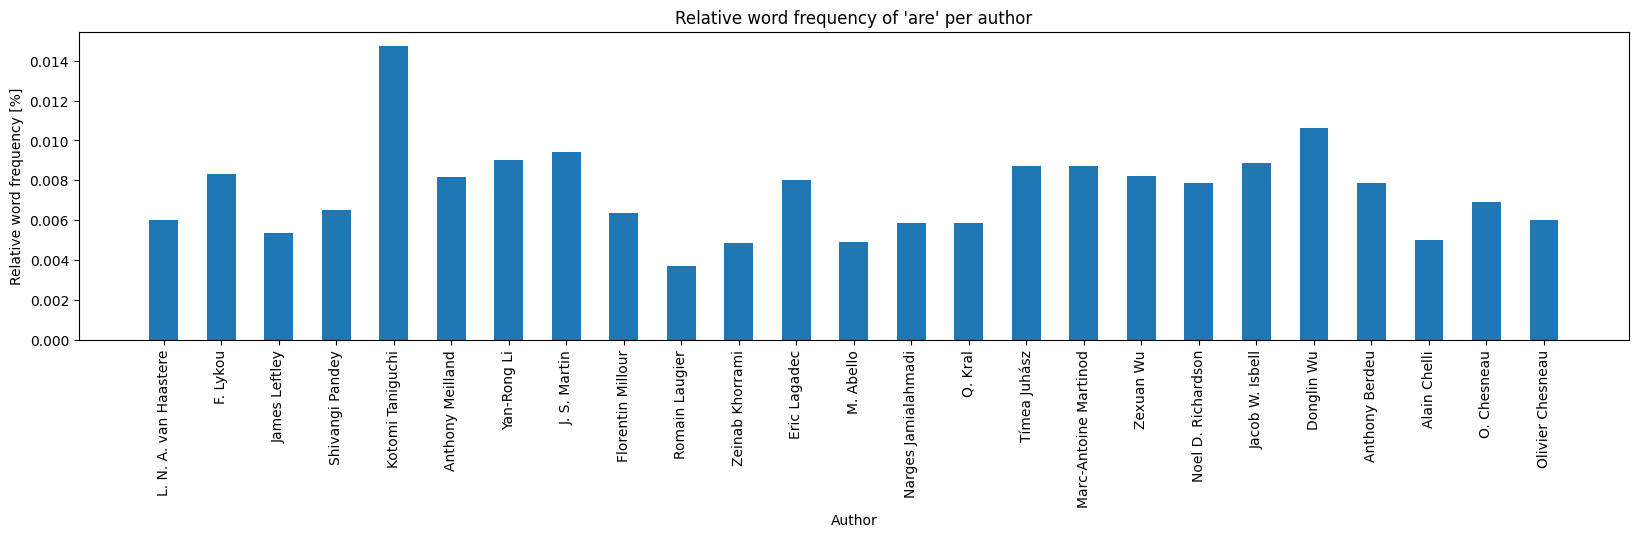

In [97]:
all_intersection_words = list(word_hist_inter_raw_df)[1:]
n_words = len(all_intersection_words)
#print(all_intersection_words)

def get_frequency_dict(word):
    frequency_dict = {}
    for author, value in word_totals.items():
        if value != 0:
            frequency_dict[author] = get_word_count_for_author(author, words=[word])/value
    return frequency_dict

def plot_word_frequency_per_author(word):
    frequency_dict = get_frequency_dict(word)
    X = np.array(list(frequency_dict.keys()))
    Y = np.array(list(frequency_dict.values()))
    plt.figure(figsize=(20, 4))
    plt.xlabel("Author")
    plt.ylabel("Relative word frequency [%]")
    plt.xticks(rotation=90)
    plt.title(f"Relative word frequency of '{word}' per author")
    bars = plt.bar(X, Y, width=0.5)
    plt.show()

#for word in all_intersection_words:
plot_word_frequency_per_author('are')
    

Investigating the relative word frequency for each paper, grouped by author (for inter vs intra group variance analysis)

In [61]:
# first, remove all authors with < n papers:

def authors_with_min_req_papers(n=3):
    """
    returns dictionary with authors who have written at least n papers as first author and the corresponding papers
    """
    author_paper_dict = {}
    for author in list_of_authors:
        paper_ids = get_paper_ids_for_author(author)
        if len(paper_ids) >= n:
            author_paper_dict[author] = paper_ids
    return author_paper_dict

author_paper_dct = authors_with_min_req_papers(n=1)

# now, plot the word frequencies of papers grouped per author
def plot_word_frequency_per_paper_grouped(word):
    i = 1
    for author, papers in author_paper_dct.items():
        n_papers = len(papers)
        X = [i] * n_papers
        Y = [get_word_count_for_paper(paper_id, words=[word])/get_word_count_for_paper(paper_id, words='all') for paper_id in papers]
        plt.plot(X,Y, 'x')
        i+=1
    plt.show()

#plot_word_frequency_per_paper_grouped('any')


Investigating how distinct the usage of a word by a specific author is, assuming gaussian distribution

In [107]:
def freq_histogram(word):
    frequency_dict = get_frequency_dict(word)
    plt.hist(np.array(list(frequency_dict.values())), bins=20)

def estimate_word_dist(word):
    frequency_dict = get_frequency_dict(word)
    frequencies = np.array(list(frequency_dict.values()))
    mu = frequencies.mean()
    var = (frequencies - mu).T @ (frequencies - mu)/frequencies.size

    #sigma = math.sqrt(var)
    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #plt.plot(x, stats.norm.pdf(x, mu, sigma))
    return mu, var
    
#freq_histogram('in')
#estimate_word_dist('and')

def p(word, author):
    mu, var = estimate_word_dist(word)
    frequency = get_frequency_dict(word)[author]
    return stats.norm.pdf(frequency, mu, math.sqrt(var))

def find_most_special_word(author):
    """
    finds the word out of all common words which is the most 'unlikely' to have the frequency this author uses it in
    'Out of all of the common words [author] uses, which one is used the most untypical way?'
    TODO: exclude author from distribution first (?)
    """
    word_p_dict = {}
    for word in all_intersection_words:
        p_val = p(word, author)
        word_p_dict[word] = p_val
    word_result = min(word_p_dict, key=word_p_dict.get)
    print(f"Most special word for {author} is '{word_result}' with p = {word_p_dict[word_result]}")
    return word_result

#sp_word = find_most_special_word('Zexuan Wu')
#plot_word_frequency_per_author(sp_word)